In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1048)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
x_data shape :  (20, 150, 150, 3)
t_data shape :  (20,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


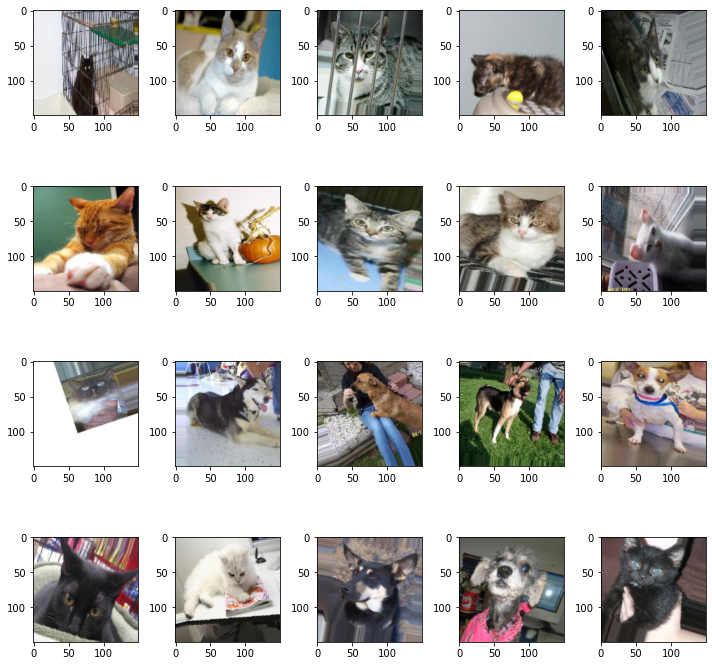

In [2]:
% matplotlib inline

import matplotlib.image as img
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats

train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'


# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=20, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   zoom_range=0.2, 
                                   shear_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['dogs','cats'], 
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary') # 다항이면 categorical
validation_generator = train_datagen.flow_from_directory(
    validation_dir, 
    classes=['dogs','cats'], 
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary') # 다항이면 categorical

# generator에서 출력된 데이터의 shape확인
for x_data, t_data in train_generator:
    print('x_data shape : ', x_data.shape) # (20,150,150,3)
    print('t_data shape : ', t_data.shape) # (20,)
    break;

fig = plt.figure(figsize=(10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
    
for x_data, t_data in train_generator:
    for idx, img_data in enumerate(x_data): # idx => 0~19 , img_data =>(150,150,3)
        axs[idx].imshow(img_data)
    print(t_data)
    break;
    
fig.tight_layout()
plt.show()



In [3]:
with tf.device('/device:GPU:1'):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    print(model.summary())
    
    # 학습실행
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=100,  #  batch_size * steps_per_epoch이 train데이타의 양보다 크면 안됨!!!!!
                        epochs=100,
                        validation_data=validation_generator,
                        validation_steps=50)
    
model.save('./cat_dog_small_argumentation_cnn_model.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

100/100 [==============================] - 20s 203ms/step - loss: 0.3771 - accuracy: 0.8250 - val_loss: 0.4730 - val_accuracy: 0.7940
Epoch 44/100
100/100 [==============================] - 20s 203ms/step - loss: 0.3888 - accuracy: 0.8200 - val_loss: 0.4676 - val_accuracy: 0.7800
Epoch 45/100
100/100 [==============================] - 20s 203ms/step - loss: 0.3703 - accuracy: 0.8345 - val_loss: 0.4535 - val_accuracy: 0.7880
Epoch 46/100
100/100 [==============================] - 20s 203ms/step - loss: 0.3543 - accuracy: 0.8430 - val_loss: 0.4611 - val_accuracy: 0.7820
Epoch 47/100
100/100 [==============================] - 20s 204ms/step - loss: 0.3478 - accuracy: 0.8415 - val_loss: 0.4359 - val_accuracy: 0.7890
Epoch 48/100
100/100 [==============================] - 20s 204ms/step - loss: 0.3613 - accuracy: 0.8465 - val_loss: 0.4440 - val_accuracy: 0.7760
Epoch 49/100
100/100 [==============================] - 20s 203ms/step - loss: 0.3467 - accuracy: 0.8435 - val_loss: 0.4427 - val_a

Epoch 99/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2268 - accuracy: 0.9055 - val_loss: 0.4552 - val_accuracy: 0.8100
Epoch 100/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2292 - accuracy: 0.9050 - val_loss: 0.4103 - val_accuracy: 0.8250


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


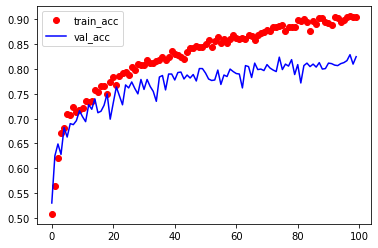

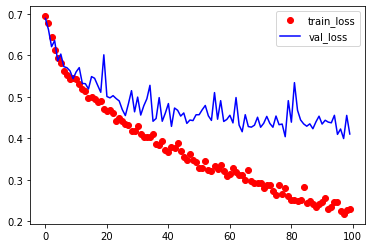

In [4]:
% matplotlib inline
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(history.history.keys())
plt.plot(history.history['accuracy'], 'bo', color='r', label='train_acc')
plt.plot(history.history['val_accuracy'], 'b', color='b', label='val_acc')
plt.legend()
plt.show()
plt.plot(history.history['loss'], 'bo', color='r', label='train_loss')
plt.plot(history.history['val_loss'], 'b', color='b', label='val_loss')
plt.legend()
plt.show()